### Local Covid deaths

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import jenkspy
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
import json
import numpy as np
import altair as alt
import altair_latimes as lat

In [4]:
import requests
from bs4 import BeautifulSoup
import re
import unicodedata
from datetime import datetime, date
from slugify import slugify

In [5]:
alt.themes.register("latimes", lat.theme)
alt.themes.enable("latimes")
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

## Download

Retrieve the page

In [6]:
url = "http://publichealth.lacounty.gov/media/Coronavirus/locations.htm"

In [7]:
page = requests.get(url)

## Parse

In [8]:
soup = BeautifulSoup(page.content, "html.parser")

Get content well

In [9]:
content = soup.find("div", {"id": "content"})

Get table

In [10]:
for tag in content.find_all(text=re.compile("CITY/COMMUNITY")):
    table = tag.findParent("table")

In [11]:
tbody = soup.tbody

In [12]:
row_list = tbody.find_all("tr")

In [13]:
dict_list = []

In [14]:
def safetxt(element):
    v = element.text.strip()
    v = v.replace("\u200b", "")
    return v

In [15]:
def safenumber(element):
    v = safetxt(element)
    v = v.replace(",", "")
    v = v.replace(" ", "")
    return v

In [16]:
for row in row_list:
    cell_content = row.find_all("td")
    d = dict(
        county="Los Angeles",
        area=safetxt(cell_content[0]),
        confirmed_cases=safenumber(cell_content[1]),
        cases_rate=safenumber(cell_content[2]),
        confirmed_deaths=safenumber(cell_content[3]),
        deaths_rate=safenumber(cell_content[4]),
    )
    dict_list.append(d)

In [17]:
df = pd.DataFrame(dict_list)

In [18]:
df.head()

,county,area,confirmed_cases,cases_rate,confirmed_deaths,deaths_rate
0,Los Angeles,City of Agoura Hills,907,4343,13,62
1,Los Angeles,City of Alhambra,6430,7414,157,181
2,Los Angeles,City of Arcadia,2477,4289,97,168
3,Los Angeles,City of Artesia,1904,11337,46,274
4,Los Angeles,City of Avalon,13,336,0,0


Get timestamp

In [19]:
date_url = "http://publichealth.lacounty.gov/media/Coronavirus/js/casecounter.js"

In [20]:
date_url

'http://publichealth.lacounty.gov/media/Coronavirus/js/casecounter.js'

In [21]:
response = requests.get(date_url)
date_page = response.text

In [22]:
date_text = re.search(r"([0-9][0-9]/[0-9][0-9])", date_page).group(1)
date_text = date_text + "/" + str(date.today().year)

In [23]:
latest_date = pd.to_datetime(date_text).date()

In [24]:
df["county_date"] = latest_date

In [25]:
df.tail(1)

,county,area,confirmed_cases,cases_rate,confirmed_deaths,deaths_rate,county_date
341,Los Angeles,- Under Investigation,21202,,67,,2021-02-09


In [26]:
df.loc[df.area == "-  Under Investigation", "area"] = "Under Investigation"

In [27]:
df.loc[df.area == "- Under Investigation", "area"] = "Under Investigation"

## Vet

In [28]:
len(df)

342

In [29]:
try:
    assert not len(df) > 342
except AssertionError:
    raise AssertionError("L.A. County's scraper has extra rows")

In [30]:
try:
    assert not len(df) < 342
except AssertionError:
    raise AssertionError("L.A. County's scraper is missing rows")

## Export

Set the date

In [31]:
now = pd.Timestamp.today()

In [32]:
latest = df["county_date"].max()

In [33]:
df.to_csv(f"output/deaths/los-angeles-{latest}.csv", index=False)

In [34]:
len(df)

342

---

In [35]:
places = df.copy()

In [36]:
places["area"] = places["area"].str.replace("*", "", regex=False)

In [37]:
places[places["area"].str.contains("Azusa")]

,county,area,confirmed_cases,cases_rate,confirmed_deaths,deaths_rate,county_date
5,Los Angeles,City of Azusa,5903,11797,89,178,2021-02-09
234,Los Angeles,Unincorporated - Azusa,2221,13948,28,176,2021-02-09


---

## Geography

### Get neighborhoods

In [38]:
hoods = gpd.read_file("input/cities-neighborhoods-unincorporated-la-county.geojson")

In [39]:
hoods = hoods.rename(columns=str.lower)

In [40]:
hoods.drop(
    [
        "shape__area",
        "shape__length",
        "confirmed",
        "suspected",
        "recovered",
        "deaths",
        "objectid",
    ],
    axis=1,
    inplace=True,
)

---

## Merge 

### Join deaths dataframe to geography

In [42]:
deaths_hoods = hoods.merge(places, left_on="label", right_on="area")

In [43]:
len(deaths_hoods)

340

<AxesSubplot:>

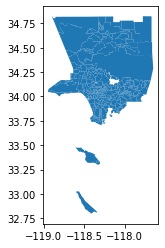

In [44]:
deaths_hoods.plot()

In [45]:
deaths_hoods[
    ["confirmed_deaths", "confirmed_cases", "cases_rate", "deaths_rate"]
] = deaths_hoods[
    ["confirmed_deaths", "confirmed_cases", "cases_rate", "deaths_rate"]
].astype(
    int
)

In [46]:
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower) / (upper - lower)
    return y

In [47]:
deaths_hoods["normalized_deaths_rate"] = normalize(deaths_hoods.deaths_rate)

In [48]:
deaths_hoods["county_date"] = pd.to_datetime(deaths_hoods["county_date"])

In [49]:
deaths_hoods.to_file("output/deaths_hoods.geojson", driver="GeoJSON")

In [50]:
deaths_hoods.head()

,lcity,community,label,geometry,county,area,confirmed_cases,cases_rate,confirmed_deaths,deaths_rate,county_date,normalized_deaths_rate
0,Agoura Hills,,City of Agoura Hills,"POLYGON ((-118.72865 34.16793, -118.73655 34.1...",Los Angeles,City of Agoura Hills,907,4343,13,62,2021-02-09,0.003044
1,Bellflower,,City of Bellflower,"POLYGON ((-118.10976 33.90982, -118.10984 33.9...",Los Angeles,City of Bellflower,10050,12929,148,190,2021-02-09,0.009327
2,Beverly Hills,,City of Beverly Hills,"POLYGON ((-118.39160 34.11243, -118.39230 34.1...",Los Angeles,City of Beverly Hills,2327,6741,25,72,2021-02-09,0.003535
3,Burbank,,City of Burbank,"POLYGON ((-118.30781 34.16116, -118.30451 34.1...",Los Angeles,City of Burbank,7852,7326,184,172,2021-02-09,0.008444
4,Calabasas,,City of Calabasas,"POLYGON ((-118.69385 34.16856, -118.69454 34.1...",Los Angeles,City of Calabasas,1078,4432,25,103,2021-02-09,0.005056


---

### Deaths over time

In [51]:
deaths_hoods.county_date.value_counts()

2021-02-09    340
Name: county_date, dtype: int64